In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Convert the json logs to table

In [135]:
def transformLogs(dirpath: str, filename: str):
    df = pd.read_json(f"{dirpath}/{filename}", orient="index")
    df = df.stack().rename_axis(["n","operation"]).reset_index(name="payload")

    df = pd.concat(
        df.apply(
            lambda row: pd.DataFrame(
                [
                    {
                        "db_size": row.n.split("_")[1],
                        "iteration": row.n.split("_")[-1],
                        "operation": row.n.split("_")[2][:-6] + row.operation if row.operation in ["create", "delete"] else row.n.split("_")[2][:-6],
                        "sample": 0,
                        **row.payload["baseline"],
                        "response_time": row.payload["response_time"],
                    },
                    *[
                        {
                            "db_size": row.n.split("_")[1],
                            "iteration": row.n.split("_")[-1],
                            "operation": row.n.split("_")[2][:-6] + row.operation if row.operation in ["create", "delete"] else row.n.split("_")[2][:-6],
                            **{k: v for k, v in sample.items()},
                            "response_time": row.payload["response_time"],
                        }
                        for sample in row.payload["samples"]
                    ],
                ]
            ),
            axis=1
        ).tolist(),
        ignore_index=True
    )

    df["instance"] = dirpath.split("/")[-1]

    df[[
        'db_size', 'iteration', 'sample', 'cpu_util',
        'disk_read', 'disk_write', 'disk_used', 'disk_free',
        'virtual_used', 'virtual_free', 'response_time'
    ]].astype(float)

    return df

results = []
for dirpath, _, filenames in os.walk("../logs/"):
    if dirpath.split("/")[-1] == "local":
        continue

    for filename in filenames:
        results.append(transformLogs(dirpath, filename))

df_raw = pd.concat(results)
df_raw

,db_size,iteration,operation,sample,cpu_util,disk_read,disk_write,disk_used,disk_free,virtual_used,virtual_free,response_time,instance
0,10,0,insertOnedelete,0,9.5,0.725337,5.550348,3.762451,24.239624,1.195541,2.551422,0.001833,medium
1,10,0,insertOnedelete,1,0.0,0.725337,5.550352,3.762451,24.239624,1.195541,2.551422,0.001833,medium
2,10,0,insertOnecreate,0,0.0,0.725337,5.550352,3.762451,24.239624,1.195526,2.551437,0.018558,medium
3,10,0,insertOnecreate,1,4.8,0.725337,5.550508,3.762463,24.239613,1.195496,2.551468,0.018558,medium
4,10,0,insertOne,0,0.0,0.725337,5.550543,3.762463,24.239613,1.195488,2.551476,0.000810,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,100000,4,aggregatecreate,1,52.0,39.670193,2.765177,4.926296,23.075779,1.039745,0.826122,0.743996,small
406,100000,4,aggregatecreate,2,47.6,39.670193,2.765295,4.926304,23.075771,1.040897,0.824970,0.743996,small
407,100000,4,aggregatecreate,3,50.0,39.670193,2.767565,4.928600,23.073475,1.038883,0.826984,0.743996,small
408,100000,4,aggregate,0,0.0,39.670193,2.769968,4.928600,23.073475,1.036495,0.829372,0.035801,small


# Calculate the total response time as database size increases

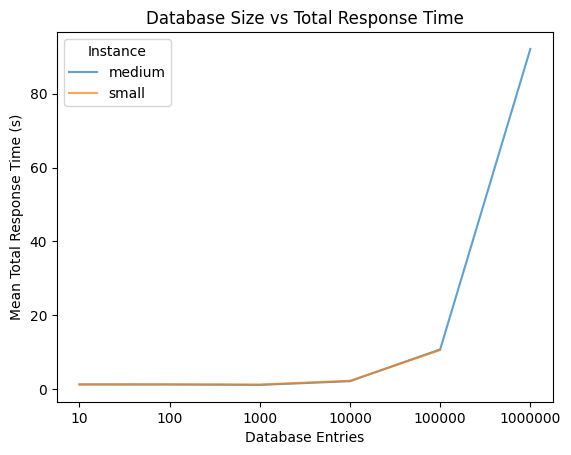

In [136]:
df = df_raw.copy(deep=True)

# filter out the base lines (before the test is run)
df = df[df["sample"] > 0]

# get the average response time of each operation
df = df.groupby(
        ["instance", "db_size", "operation"]
    )["response_time"].agg(
        ["mean"]
    ).reset_index()

# get the total response time across all the operations
df = df.groupby(
        ["instance", "db_size"]
    )["mean"].sum().reset_index()

# plot the results
plt.figure()

# plot each vm instance
for inst in df["instance"].unique():
    # filter to get subset
    subset = df[df["instance"] == inst]
    
    # plot size and average response time
    plt.plot(subset["db_size"], subset["mean"], label=inst, alpha=0.7)

# set the labels and titles
plt.xlabel("Database Entries")
plt.ylabel("Mean Total Response Time (s)")
plt.legend(title="Instance")
plt.title("Database Size vs Total Response Time")
plt.show()